# Notebook 01: Measuring Inequality

## What does it mean that inequality is greater in one place vs. another?

"Inequality" is not a single number. Different measures emphasize different parts
of the income distribution, and they can rank countries differently. This notebook
explores the main measures and shows why measure choice matters.

### Key measures

| Measure | What it captures | Sensitive to |
|---------|-----------------|-------------|
| **Gini coefficient** | Area between Lorenz curve and the line of equality | Middle of distribution |
| **Palma ratio** | Top 10% share / Bottom 40% share | Tails (top and bottom) |
| **P90/P10 ratio** | Income at 90th percentile / income at 10th | Upper and lower bounds |
| **Top 1% share** | Share of total income going to the richest 1% | Very top |
| **Theil index** | Information-theoretic measure | Decomposable by subgroup |

### Why this matters

The Gini coefficient is the most widely cited measure, but it is **most sensitive
to transfers in the middle** of the distribution and relatively insensitive to
changes at the very top or very bottom — precisely where most policy debates focus.
Two countries can have the same Gini but very different distributional shapes.

In [2]:
import sys
sys.path.insert(0, '..')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns

from data.config import FOCUS_COUNTRIES, EXTENDED_COUNTRIES, COUNTRY_NAMES, COUNTRY_COLORS
from data.plotting import set_style, country_color, country_name, lorenz_curve, save_figure
from data import swiid, wid
from data.measures import gini_from_shares, palma_ratio

set_style()

***
## 1. Lorenz Curves: Visualizing the Shape of Inequality

The **Lorenz curve** plots the cumulative share of income received by the
bottom x% of the population. The further the curve sags below the 45° line
(perfect equality), the more unequal the distribution.

The **Gini coefficient** equals twice the area between the Lorenz curve and
the line of equality. But — crucially — very different curves can enclose
the same area (and thus produce the same Gini).

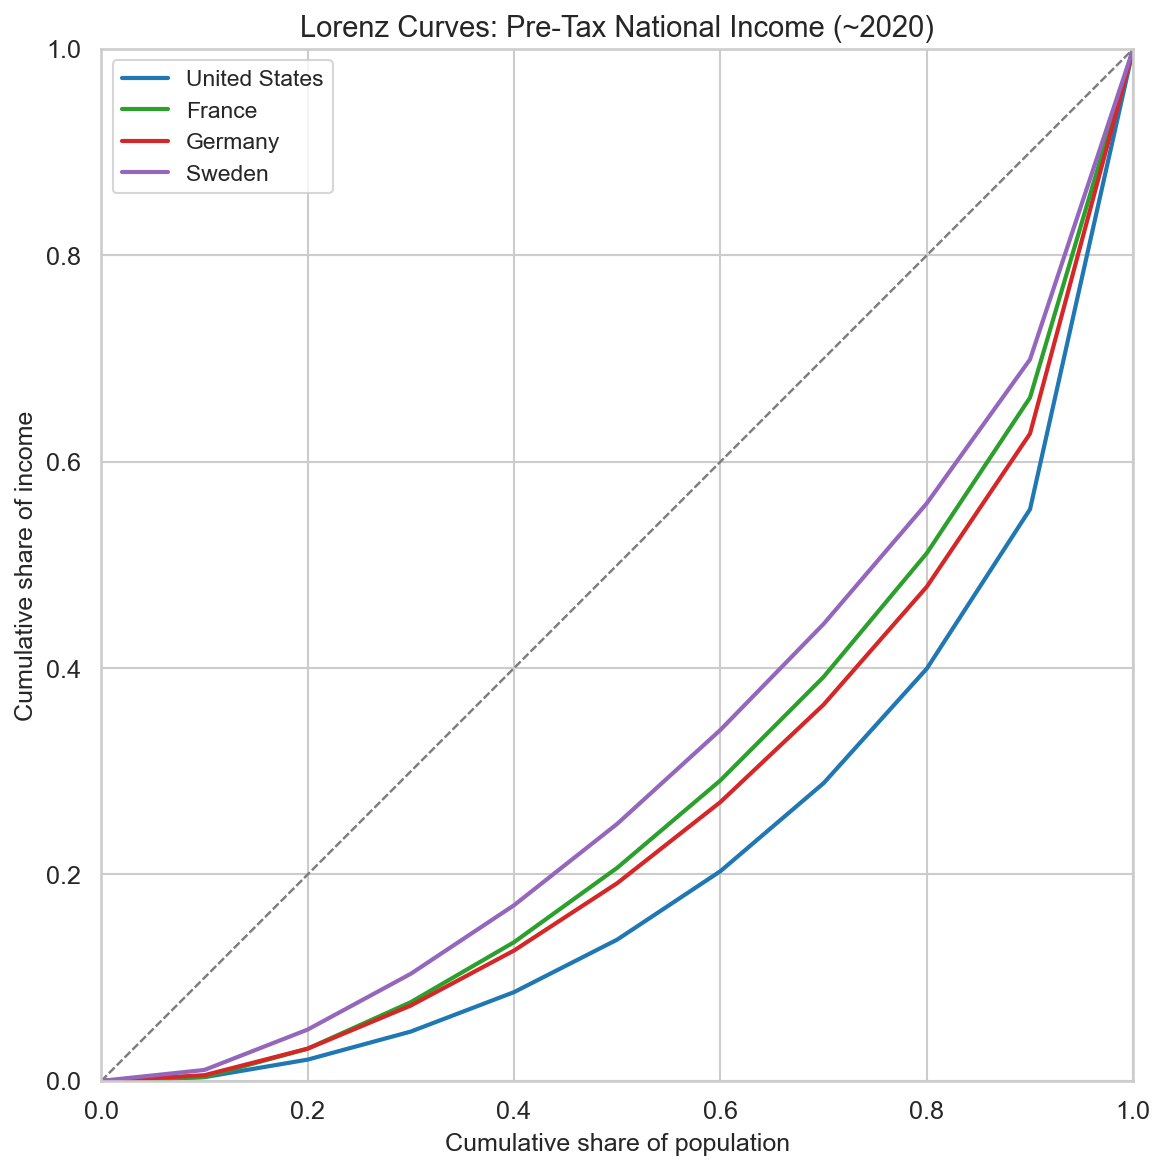

In [3]:
# Get income shares by decile from WID for Lorenz curves
# We need the 10 decile shares: p0p10, p10p20, ..., p90p100
decile_percentiles = [f"p{i*10}p{(i+1)*10}" for i in range(10)]

lorenz_countries = ['US', 'FR', 'DE', 'SE']
target_year = 2020

# Get pre-tax income shares by decile
shares_data = wid.get_income_shares(
    lorenz_countries,
    income_concept='pretax',
    percentiles=decile_percentiles,
    start_year=target_year - 2,
    end_year=target_year + 2,
)

# Take the year closest to target for each country
if not shares_data.empty:
    shares_data['year_diff'] = abs(shares_data['year'] - target_year)
    closest = (shares_data.sort_values('year_diff')
               .groupby(['country', 'percentile'])
               .first()
               .reset_index())
    
    fig, ax = plt.subplots(figsize=(8, 8))
    
    for cc in lorenz_countries:
        country_shares = closest[closest['country'] == cc].sort_values('percentile')
        if len(country_shares) == 10:
            lorenz_curve(ax, country_shares['value'].values,
                        label=country_name(cc), color=country_color(cc))
    
    ax.set_title('Lorenz Curves: Pre-Tax National Income (~2020)', fontsize=14)
    ax.legend(loc='upper left', fontsize=11)
    plt.tight_layout()
    save_figure(fig, '01_lorenz_curves')
    plt.show()
else:
    print("WID decile shares not available. Check WID data download.")

***
## 2. Market vs. Disposable Income Gini

The gap between the **market income Gini** (before taxes and transfers) and the
**disposable income Gini** (after taxes and transfers) measures how much
redistribution a country's fiscal system achieves.

Key observations:
- Nordic countries have moderate pre-tax inequality but achieve very low post-tax inequality through redistribution
- The US has high pre-tax inequality AND less redistribution, leading to very high disposable-income inequality
- Some European countries (e.g., France, Belgium) redistribute aggressively, compressing a high market Gini

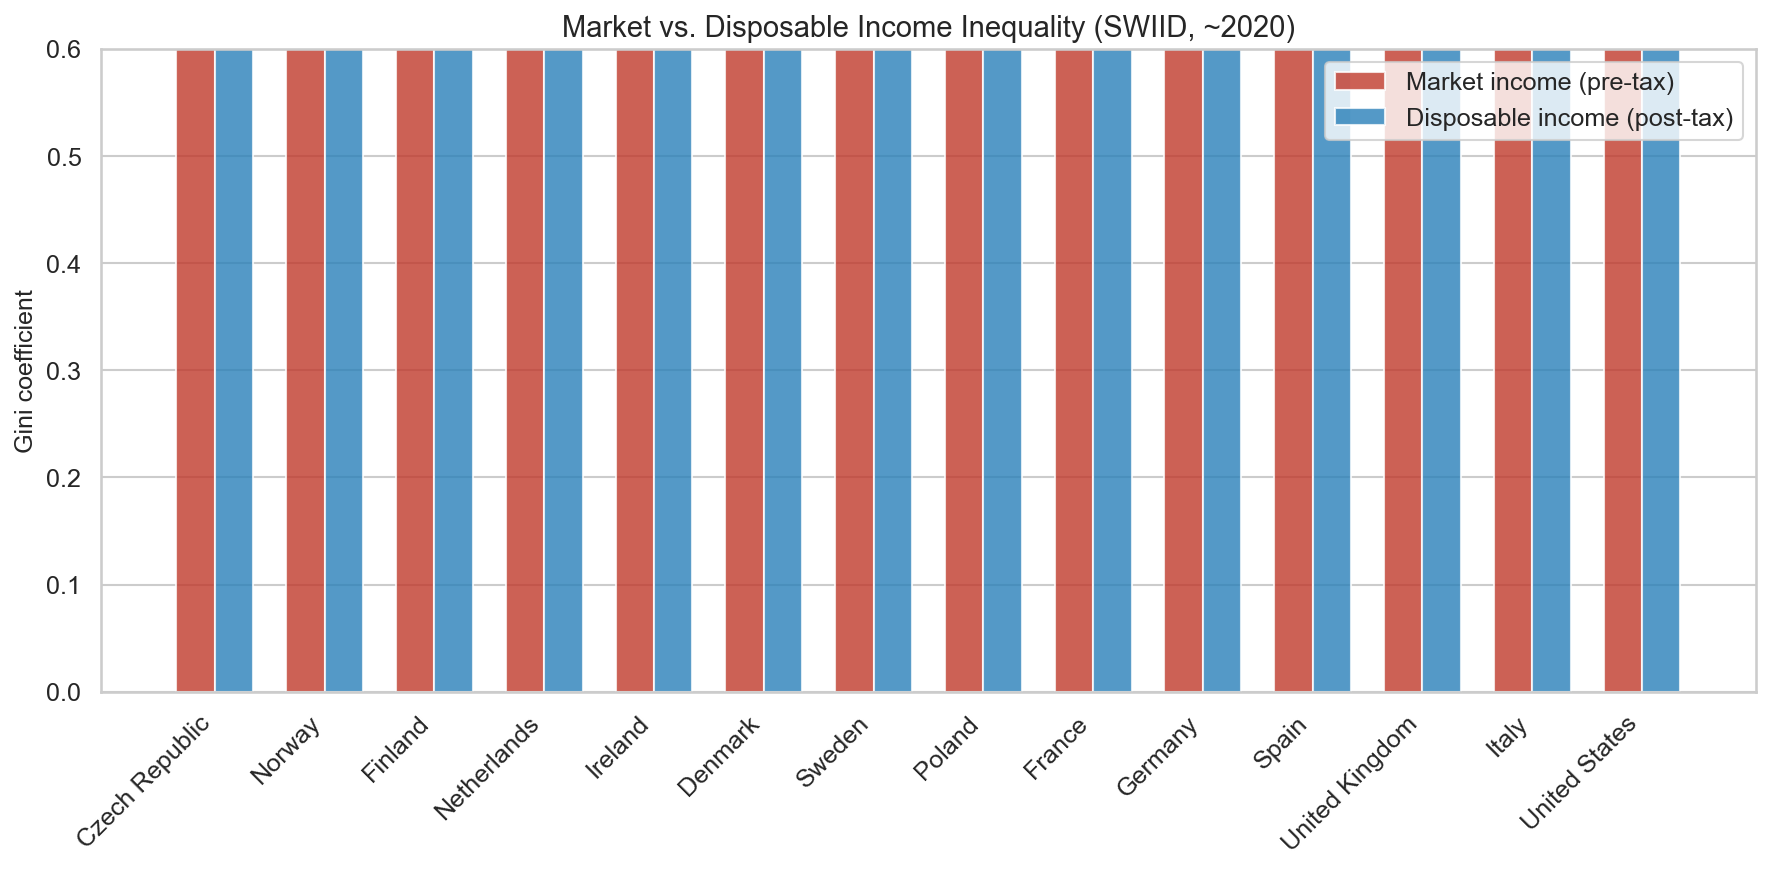

In [4]:
# Get both market and disposable Gini from SWIID
countries_for_comparison = EXTENDED_COUNTRIES
latest_year = 2020

gini_mkt = swiid.get_gini(countries_for_comparison, gini_type='mkt',
                           start_year=latest_year - 3, end_year=latest_year + 2)
gini_disp = swiid.get_gini(countries_for_comparison, gini_type='disp',
                            start_year=latest_year - 3, end_year=latest_year + 2)

# Take most recent year per country
if not gini_mkt.empty and not gini_disp.empty:
    latest_mkt = (gini_mkt.sort_values('year', ascending=False)
                  .groupby('country_code').first().reset_index())
    latest_disp = (gini_disp.sort_values('year', ascending=False)
                   .groupby('country_code').first().reset_index())
    
    merged = latest_mkt[['country_code', 'country_name', 'gini']].merge(
        latest_disp[['country_code', 'gini']],
        on='country_code', suffixes=('_mkt', '_disp')
    )
    merged = merged.dropna().sort_values('gini_disp')
    
    # Grouped bar chart
    fig, ax = plt.subplots(figsize=(12, 6))
    x = np.arange(len(merged))
    width = 0.35
    
    bars_mkt = ax.bar(x - width/2, merged['gini_mkt'], width,
                       label='Market income (pre-tax)', color='#c0392b', alpha=0.8)
    bars_disp = ax.bar(x + width/2, merged['gini_disp'], width,
                        label='Disposable income (post-tax)', color='#2980b9', alpha=0.8)
    
    ax.set_xticks(x)
    ax.set_xticklabels([country_name(c) for c in merged['country_code']],
                        rotation=45, ha='right')
    ax.set_ylabel('Gini coefficient')
    ax.set_title('Market vs. Disposable Income Inequality (SWIID, ~2020)', fontsize=14)
    ax.legend()
    ax.set_ylim(0, 0.6)
    
    # Add redistribution arrows for focus countries
    for i, row in merged.iterrows():
        idx = merged.index.get_loc(i)
        reduction = row['gini_mkt'] - row['gini_disp']
        ax.annotate(f'{reduction:.2f}',
                   xy=(idx, row['gini_disp'] + reduction/2),
                   fontsize=7, ha='center', color='#555', rotation=90)
    
    plt.tight_layout()
    save_figure(fig, '01_market_vs_disposable_gini')
    plt.show()
else:
    print("SWIID data not available for this query.")

***
## 3. Measure Comparison Heatmap: Do Different Measures Agree?

Here we rank the same set of countries by multiple inequality measures.
If all measures captured the same thing, the rankings would be identical.
They are not — and the disagreements are informative.

A country that ranks high on the Gini but low on the top 1% share has
inequality concentrated in the middle of the distribution rather than at the
very top.

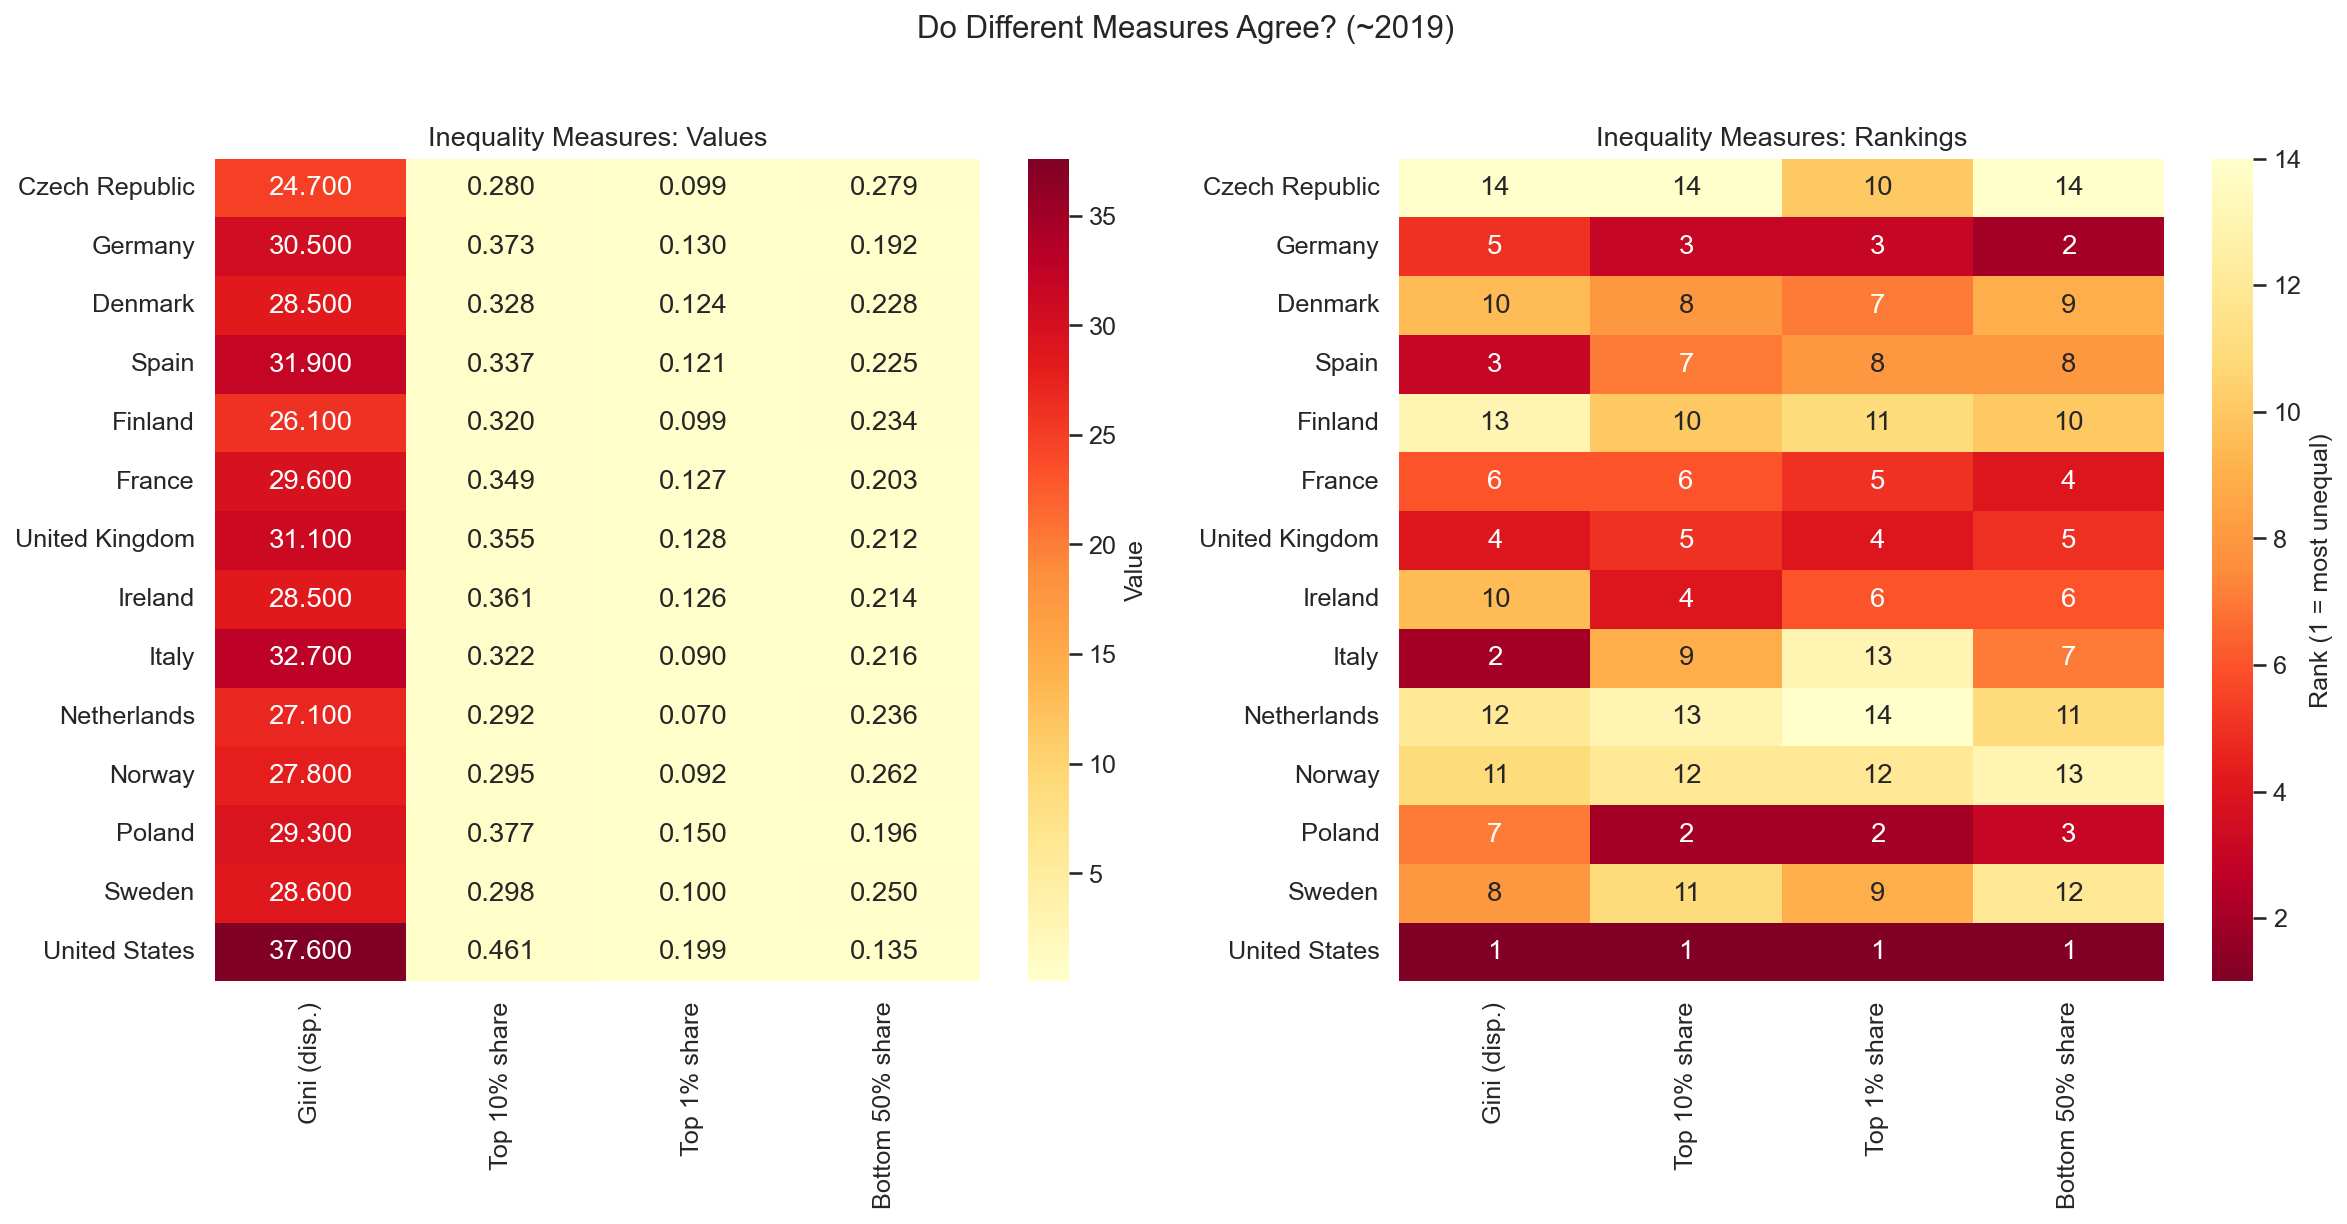


Notable rank differences (measure disagreements):
  Czech Republic: ranks range from 10 to 14
  Spain: ranks range from 3 to 8
  Ireland: ranks range from 4 to 10
  Italy: ranks range from 2 to 13
  Poland: ranks range from 2 to 7
  Sweden: ranks range from 8 to 12


In [5]:
# Collect multiple inequality measures for the same countries and year
comparison_countries = EXTENDED_COUNTRIES
comp_year = 2019

# Gini (disposable) from SWIID
gini_data = swiid.get_gini(comparison_countries, gini_type='disp',
                            start_year=comp_year - 2, end_year=comp_year + 2)

# Top 10% and Top 1% pre-tax income shares from WID
top_shares = wid.get_income_shares(
    comparison_countries,
    income_concept='pretax',
    percentiles=['p90p100', 'p99p100', 'p0p50'],
    start_year=comp_year - 2,
    end_year=comp_year + 2,
)

# Build comparison table
measures = {}

# Latest Gini per country
if not gini_data.empty:
    g = (gini_data.sort_values('year', ascending=False)
         .groupby('country_code')['gini'].first())
    measures['Gini (disp.)'] = g

# Top shares
if not top_shares.empty:
    for pct, label in [('p90p100', 'Top 10%'), ('p99p100', 'Top 1%'), ('p0p50', 'Bottom 50%')]:
        sub = top_shares[top_shares['percentile'] == pct]
        if not sub.empty:
            s = (sub.sort_values('year', ascending=False)
                 .groupby('country')['value'].first())
            measures[f'{label} share'] = s

if measures:
    comp_df = pd.DataFrame(measures)
    comp_df.index.name = 'country'
    comp_df = comp_df.dropna(how='all')
    
    # Compute ranks (1 = most unequal)
    rank_df = comp_df.copy()
    for col in rank_df.columns:
        if 'Bottom' in col:
            # Lower bottom 50% share = more unequal
            rank_df[col] = rank_df[col].rank(ascending=True)
        else:
            # Higher Gini / top share = more unequal
            rank_df[col] = rank_df[col].rank(ascending=False)
    
    # Plot heatmap of ranks
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
    
    # Values heatmap
    display_df = comp_df.copy()
    display_df.index = [country_name(c) if c in COUNTRY_NAMES else c for c in display_df.index]
    sns.heatmap(display_df, annot=True, fmt='.3f', cmap='YlOrRd',
                ax=ax1, cbar_kws={'label': 'Value'})
    ax1.set_title('Inequality Measures: Values', fontsize=13)
    
    # Rank heatmap
    rank_display = rank_df.copy()
    rank_display.index = [country_name(c) if c in COUNTRY_NAMES else c for c in rank_display.index]
    sns.heatmap(rank_display, annot=True, fmt='.0f', cmap='YlOrRd_r',
                ax=ax2, cbar_kws={'label': 'Rank (1 = most unequal)'})
    ax2.set_title('Inequality Measures: Rankings', fontsize=13)
    
    plt.suptitle(f'Do Different Measures Agree? (~{comp_year})', fontsize=15, y=1.02)
    plt.tight_layout()
    save_figure(fig, '01_measure_comparison_heatmap')
    plt.show()
    
    # Print rank reversals
    print("\nNotable rank differences (measure disagreements):")
    for idx in rank_df.index:
        ranks = rank_df.loc[idx]
        if ranks.max() - ranks.min() >= 4:
            name = country_name(idx) if idx in COUNTRY_NAMES else idx
            print(f"  {name}: ranks range from {ranks.min():.0f} to {ranks.max():.0f}")
else:
    print("Insufficient data to build comparison table.")

***
## 4. US Gini vs. Top 1% Share Over Time

This is perhaps the clearest illustration of why measure choice matters.

The US **Gini coefficient** (from the Census Bureau) rose modestly from about
0.39 in 1970 to about 0.49 in 2020 — a meaningful but not dramatic increase.

The US **top 1% pre-tax income share** (from WID) roughly doubled from ~10% to
~20% over the same period — a far more dramatic change.

The divergence occurs because the Gini is insensitive to changes within the top
decile. The massive gains at the very top barely move the Gini, but they
dominate the top 1% share measure.

In [6]:
from data import census

# US Census Gini time series
us_gini_ts = census.get_us_gini_timeseries(start_year=1970)

# WID top 1% pre-tax income share for US
us_top1 = wid.get_top_shares_timeseries(
    ['US'], percentile='p99p100', concept='pretax', start_year=1970
)

if not us_gini_ts.empty and not us_top1.empty:
    fig, ax1 = plt.subplots(figsize=(12, 6))
    
    # Gini on left axis
    color1 = '#2980b9'
    ax1.plot(us_gini_ts['year'], us_gini_ts['gini'],
             color=color1, linewidth=2, label='Gini coefficient (Census)')
    ax1.set_xlabel('Year')
    ax1.set_ylabel('Gini coefficient', color=color1)
    ax1.tick_params(axis='y', labelcolor=color1)
    ax1.set_ylim(0.3, 0.55)
    
    # Top 1% share on right axis
    ax2 = ax1.twinx()
    color2 = '#c0392b'
    ax2.plot(us_top1['year'], us_top1['value'],
             color=color2, linewidth=2, linestyle='--',
             label='Top 1% income share (WID)')
    ax2.set_ylabel('Top 1% pre-tax income share', color=color2)
    ax2.tick_params(axis='y', labelcolor=color2)
    ax2.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    ax2.set_ylim(0.05, 0.25)
    
    # Combined legend
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')
    
    ax1.set_title('United States: Gini vs. Top 1% Share (1970-present)\n'
                  'The Gini understates the rise in top-end inequality',
                  fontsize=13)
    
    plt.tight_layout()
    save_figure(fig, '01_us_gini_vs_top1')
    plt.show()
else:
    if us_gini_ts.empty:
        print("Census Gini data not available.")
    if us_top1.empty:
        print("WID top 1% share data not available.")

ReadTimeout: HTTPSConnectionPool(host='www2.census.gov', port=443): Read timed out. (read timeout=60)

***
## 5. Top Income Shares: US vs. Europe Over Time

How has the top 10% income share evolved differently in the US vs. major
European countries? The divergence since 1980 is one of the central facts
in the inequality literature.

In [ ]:
# Top 10% pre-tax income share time series
ts_countries = ['US', 'FR', 'DE', 'SE', 'GB']

top10_ts = wid.get_top_shares_timeseries(
    ts_countries, percentile='p90p100', concept='pretax', start_year=1970
)

if not top10_ts.empty:
    fig, ax = plt.subplots(figsize=(12, 6))
    
    for cc in ts_countries:
        country_data = top10_ts[top10_ts['country'] == cc].sort_values('year')
        if not country_data.empty:
            ax.plot(country_data['year'], country_data['value'],
                    color=country_color(cc), linewidth=2,
                    label=country_name(cc))
    
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    ax.set_xlabel('Year')
    ax.set_ylabel('Top 10% pre-tax income share')
    ax.set_title('Top 10% Income Share: US vs. Europe (1970-present)', fontsize=14)
    ax.legend()
    
    # Annotate the divergence
    ax.axvline(x=1980, color='gray', linestyle=':', alpha=0.5)
    ax.text(1981, ax.get_ylim()[1] * 0.95, '1980',
            fontsize=9, color='gray', va='top')
    
    plt.tight_layout()
    save_figure(fig, '01_top10_share_timeseries')
    plt.show()
else:
    print("WID time series data not available.")

***
## Key Takeaways

1. **No single measure captures "inequality"** — the Gini, Palma ratio, top income
   shares, and percentile ratios each tell a different story because they weight
   different parts of the distribution differently.

2. **The Gini understates top-end changes.** In the US, the top 1% share roughly
   doubled since 1980 while the Gini rose only modestly. If your concern is
   concentration at the very top, the Gini is the wrong measure.

3. **Redistribution matters, but so does predistribution.** The gap between market
   and disposable income Gini shows how much the tax-transfer system compresses
   inequality — but European countries also start from lower pre-tax inequality,
   which we explore in Notebook 02.

4. **Country rankings shift with the measure.** A country can be relatively equal
   by one measure and relatively unequal by another (the Scandinavian wealth-income
   paradox explored in Notebook 04 is the most dramatic example).